In [1]:
import fastai2
from fastai2.layers import *
from fastai2.torch_imports import *
from torch.nn.utils import weight_norm, spectral_norm
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *

## Data

In [2]:
# path = Path('/home/jupyter/data/coco'); path.ls(), len(get_image_files(path))
path = untar_data(URLs.COCO_SAMPLE)/'train_sample'; path.ls(), len(get_image_files(path))

((#21837) [/home/jupyter/.fastai/data/coco_sample/train_sample/000000538424.jpg,/home/jupyter/.fastai/data/coco_sample/train_sample/000000342206.jpg,/home/jupyter/.fastai/data/coco_sample/train_sample/000000209166.jpg,/home/jupyter/.fastai/data/coco_sample/train_sample/000000385882.jpg,/home/jupyter/.fastai/data/coco_sample/train_sample/000000131208.jpg,/home/jupyter/.fastai/data/coco_sample/train_sample/000000367528.jpg,/home/jupyter/.fastai/data/coco_sample/train_sample/000000575701.jpg,/home/jupyter/.fastai/data/coco_sample/train_sample/000000370899.jpg,/home/jupyter/.fastai/data/coco_sample/train_sample/000000115791.jpg,/home/jupyter/.fastai/data/coco_sample/train_sample/000000323862.jpg...],
 21837)

In [3]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=lambda *a, **kw: get_image_files(*a, **kw),
                   splitter=RandomSplitter(0.1, seed=42),
                   get_y=lambda x: x,
                 )

In [4]:
bs, sz = 28, 256
dbch = dblock.databunch(path, bs=bs, item_tfms=[Resize(sz)], batch_tfms=[*aug_transforms(), Normalize(*imagenet_stats)])
dbch.c = 3

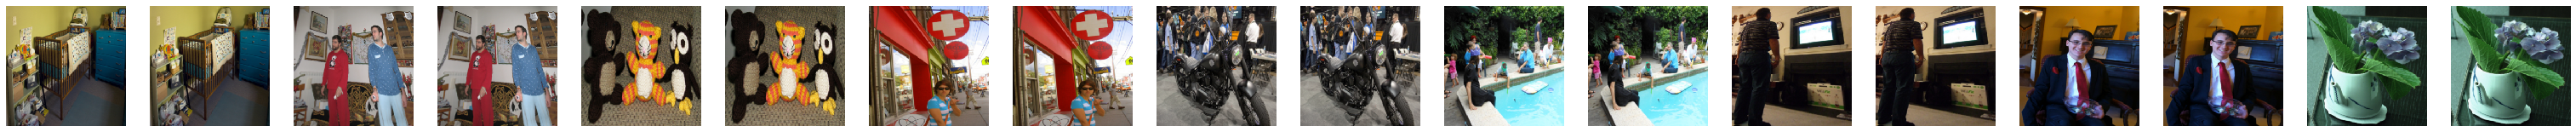

In [5]:
dbch.show_batch(rows=1)

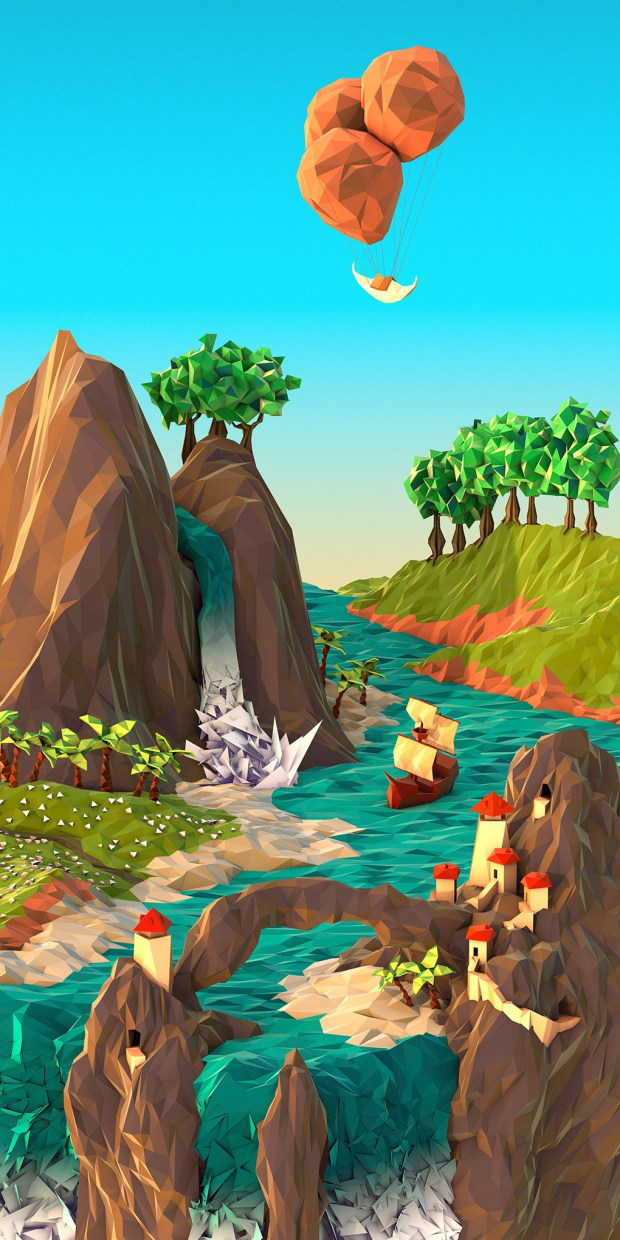

In [6]:
# How can I be sure this is working correctly?
fn = 'styles/landscape_cove.jpg'
pipe = Pipeline([PILImage.create, ToTensor(), IntToFloatTensor(), Normalize(*imagenet_stats, cuda=False)])
style_timg = TensorImage(pipe(fn).cuda());
PILImage.create(fn)

## Loss func

In [7]:
def gram(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [8]:
base_loss = F.l1_loss
class FSTLoss(nn.Module):
    def __init__(self, m_feat, cnt_ls, stl_ls, cnt_lsw, stl_lsw, stl_loss_mult=1e6):
        super().__init__()
        assert len(cnt_ls) == len(cnt_lsw)
        assert len(stl_ls) == len(stl_lsw)
        self.m_feat,self.cnt_ls,self.stl_ls,self.stl_loss_mult=m_feat,cnt_ls,stl_ls,stl_loss_mult
        self.cnt_lsw = tensor(cnt_lsw).float() / sum(cnt_lsw)
        self.stl_lsw = tensor(stl_lsw).float() / sum(stl_lsw)
        self.cnt_hooks = hook_outputs(cnt_ls, detach=False)
        self.stl_hooks = hook_outputs(stl_ls, detach=False)
        self.metric_names = ['style', 'content']
        # TODO: Temporary
        self.reset_metrics()
        
    def reset_metrics(self): self.metrics = dict(style=[], content=[])
        
    def register_style(self, timg):  _,self.stl_fs = self.get_fs(timg, True)

    def get_fs(self, x, clone=False):
        self.m_feat(x)
        cnt_fs = [(o.clone() if clone else o) for o in self.cnt_hooks.stored]
        stl_fs = [(o.clone() if clone else o) for o in self.stl_hooks.stored]
        return cnt_fs, stl_fs
    
    def forward(self, pred, targ, **kwargs):
        pred_cnt_fs, pred_stl_fs = self.get_fs(pred, True)
        targ_cnt_fs, targ_stl_fs = self.get_fs(targ)
        stl_loss = self.stl_loss_mult*self._stl_loss(pred_stl_fs)
        cnt_loss = self._cnt_loss(pred,targ,pred_cnt_fs,targ_cnt_fs)
        # self.metrics = dict(zip(self.metric_names, [stl_loss, cnt_loss]))
        self.metrics['style'].append(stl_loss); self.metrics['content'].append(cnt_loss)
        return stl_loss + cnt_loss
        
    def _stl_loss(self, pred_fs):
        stl_loss = [base_loss(gram(pred_f),gram(style_f))*w
                    for pred_f,style_f,w in zip(pred_fs,self.stl_fs,self.stl_lsw)]
        return sum(stl_loss)
    
    def _cnt_loss(self, pred, targ, pred_fs, targ_fs):
        cnt_loss =  [base_loss(pred,targ)]
        cnt_loss += [base_loss(pred_f,targ_f)*w for pred_f,targ_f,w
                     in zip(pred_fs,targ_fs,self.cnt_lsw)]
        cnt_loss += [base_loss(gram(pred_f),gram(targ_f))*w for pred_f,targ_f,w
                     in zip(pred_fs,targ_fs,self.cnt_lsw)]
        return sum(cnt_loss)

In [9]:
vgg_m = vgg16_bn(True).features.cuda().eval()
for p in vgg_m.parameters(): p.requires_grad = False
vgg_m.eval(); requires_grad(vgg_m)

False

In [10]:
blocks = [i-1 for i,o in enumerate(vgg_m.children()) if isinstance(o,nn.MaxPool2d)]
bnecks = [vgg_m[i] for i in blocks]

In [11]:
fst_loss = FSTLoss(vgg_m, cnt_ls =bnecks[3:4], stl_ls= bnecks[1:],
                          cnt_lsw=[1]      , stl_lsw=[1, 1, 1, 1], stl_loss_mult=1e5)
fst_loss.register_style(style_timg)

In [12]:
opt_func = lambda ps, lr, **kwargs: Lookahead(RAdam(ps, lr, **kwargs))

## Transformer net

In [13]:
Conv = partial(ConvLayer, norm_type=NormType.Instance)
Res = partial(ResBlock, 1, norm_type=NormType.Instance, sa=True)
tn = nn.Sequential(
    Conv(3, 32, stride=2),
    Conv(32, 32, stride=1),
    Conv(32, 64, stride=1),
    Conv(64, 64, stride=2),
    Conv(64, 128, stride=2),
    Res(128, 128),
    Res(128, 128),
    Res(128, 128),
    Res(128, 128),
    Res(128, 128),
)
utn = DynamicUnet(tn, 3, (256, 256), norm_type=NormType.Instance, blur=True, self_attention=True, y_range=(-3, 3))

In [14]:
learn = Learner(dbch, utn, loss_func=fst_loss, opt_func=opt_func)

In [15]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning) # Annoying pytorch broadcast warning: (torch.Size([1, 512, 512])) that is different to the input size (torch.Size([32, 512, 512]))

In [21]:
learn.load('utn-cove-256')

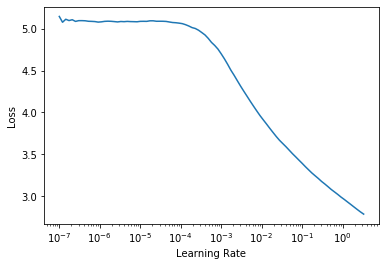

In [16]:
learn.lr_find()

In [ ]:
# lr:1e-1   - 1.07
# lr:4e-2   - 1.037

In [17]:
learn.fit_flat_cos(1, 4e-2)

In [55]:
learn.save('utn-cove-256_1')

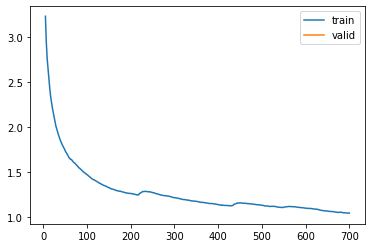

In [17]:
learn.recorder.plot_loss()

In [32]:
fst_loss.reset_metrics()

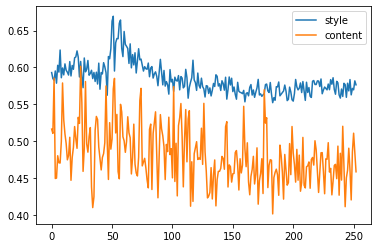

In [24]:
for n, v in fst_loss.metrics.items(): plt.plot(v[500:], label=n)
plt.legend()

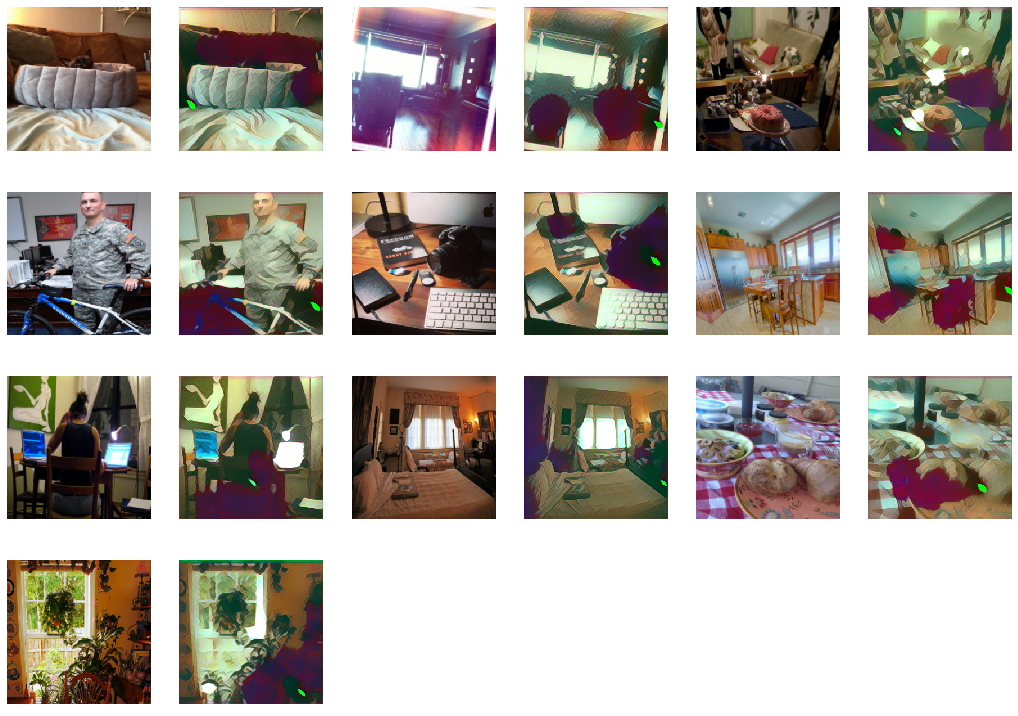

In [25]:
learn.show_results()

In [21]:
test_pipe = Pipeline([PILImage.create, ToTensor(), IntToFloatTensor(), Normalize(*imagenet_stats, cuda=False)])

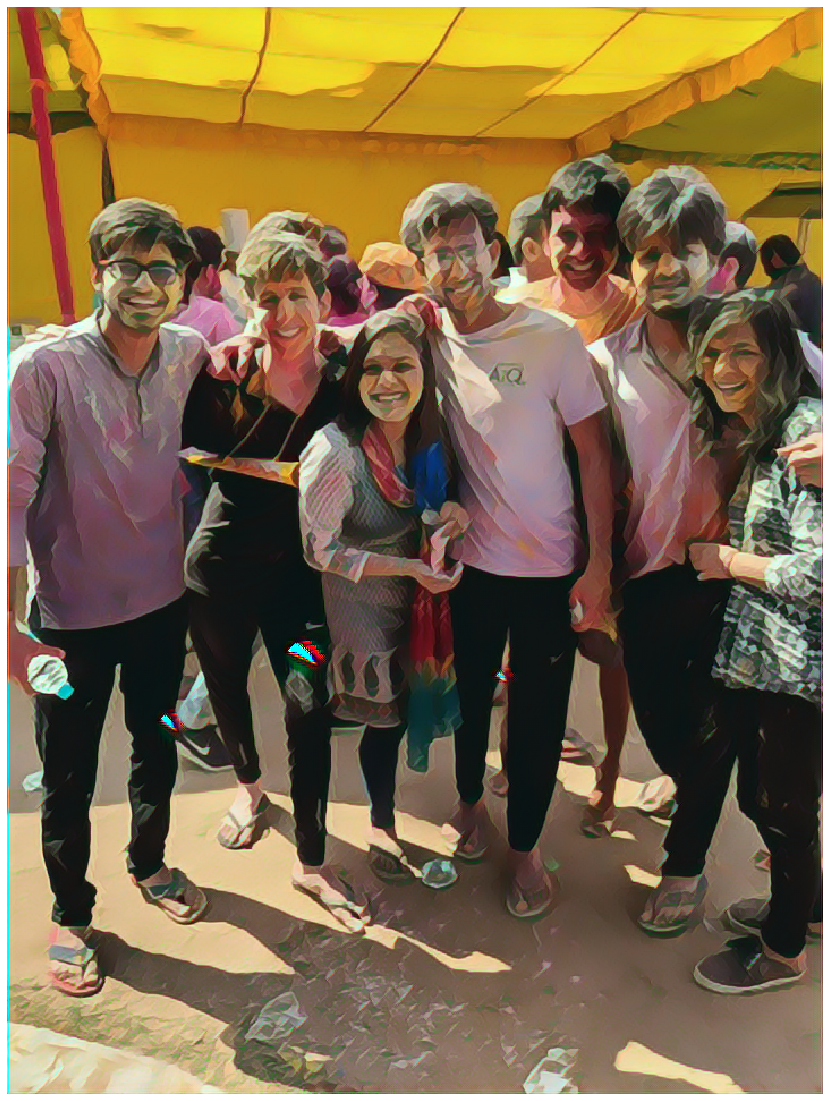

In [38]:
show_images(test_pipe.decode(pred), figsize=(20,20))

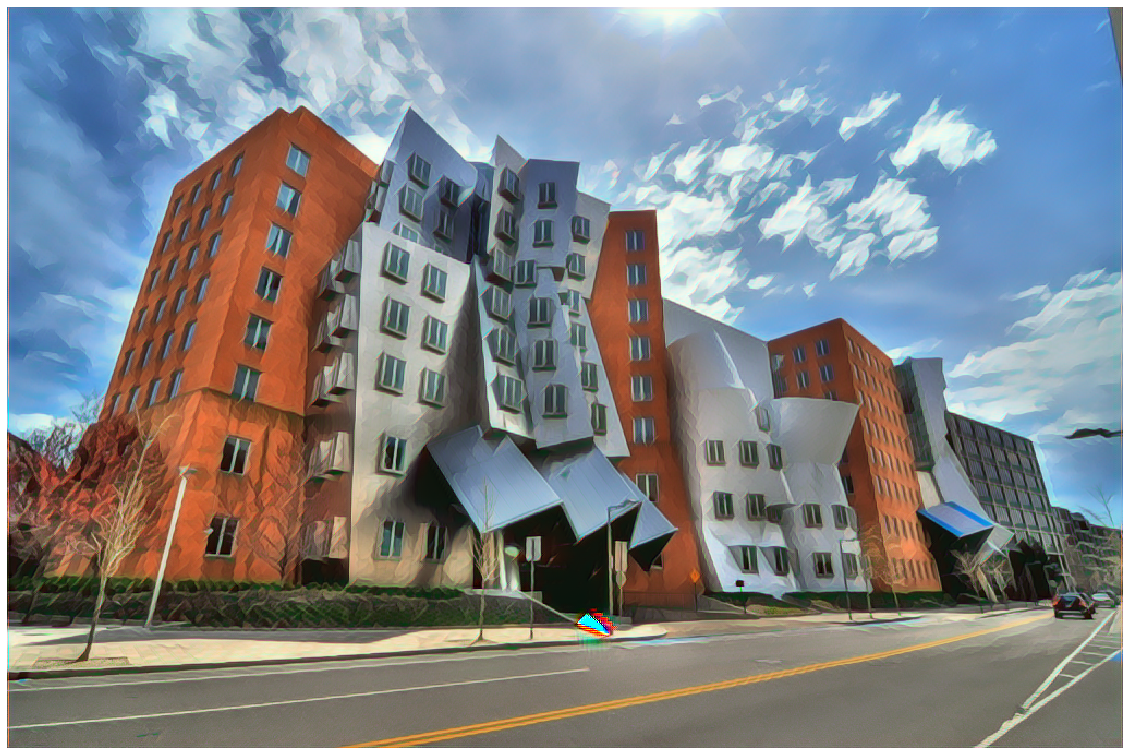

In [33]:
show_images(test_pipe.decode(pred), figsize=(20,20))